# Exploring the Relationship Between the Meta Scores of Films and the Reviews of the General Audiance


## Introduction:
IMDB is an online database for films, television series, podcasts, and other media. This project will be working with movie data from IMDB. The data set of interest contains content data - including cast, production crew, plot summary, and scores. IMDB presents two kinds of scores; IMDB scores which are user-generated averages of reviews submitted to IMDB by the general audience, and Meta Scores which are critic-generated, representing the views of professionals who analyze films.

The goal of this project is to answer the following question:
"How accurate are the Meta Scores of films in predicting the reception of the general audience?"


The data set is from Kaggle, and includes data from the top 1000 movies based on the IMDB score. The data set includes the following columns:
* Series_Title: the name of the film
* Released_year: year it was released
* Certificate: certificate earned by the movie
* Runtime - total runtime
* Genre - list of genres the film falls into
* IMDB_Rating - the IMDB rating given by IMDB user reviews
* Overview - plot summary
* Meta_score - meta score of the movie determined by movie critics
* Director - name of the director of the movie
* Star1, Star2, Star3, Star4 - names of the stars of the movie in order of significance
* No_of_votes - number of reviews on IMDB
* Gross - how much money the movie earned

Dataset Origin: https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows

#### 1. Import Libraries
Tidyverse, dplyr, and tidymodels libraries were imported for data manipulation and visualization.

In [1]:
library(tidyverse)
library(dplyr)
library(tidymodels)
options(repr.matrix.max.rows = 8)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

#### 2. Reading Data from Github
The data was downloaded from: https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows
then added to this project's repository. The following cell reads the data from the repository as a CSV file and filters for films released after 1970, as these films will represent modern conditions better.

In [2]:
url <- "https://github.com/anh-dong/dsci-100-2023w1-group-33/blob/main/data/imdb_top_1000.csv?raw=true"
movies <- read_csv(url) |>
    filter(Released_Year > 1970) |>
    select(IMDB_Rating, Meta_score) |>
    na.omit()

Rows: 1000 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (12): Poster_Link, Series_Title, Released_Year, Certificate, Runtime, Ge...
dbl  (3): IMDB_Rating, Meta_score, No_of_Votes
num  (1): Gross

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### 3. Create a training data set
The raw data is then split into a training and testing set of 75% and 25% of the raw data respectively.

In [3]:
set.seed(1234)

movies_split <- initial_split(movies, prop = 0.75, strata = Meta_score)
movies_training <- training(movies_split)
movies_testing <- testing(movies_split)



A plot of IMDB_Rating vs Meta_score was created using ggplot and geom_point. Since there was significant overlap between many data points, an alpha of 0.2 was used to visualize all the data.

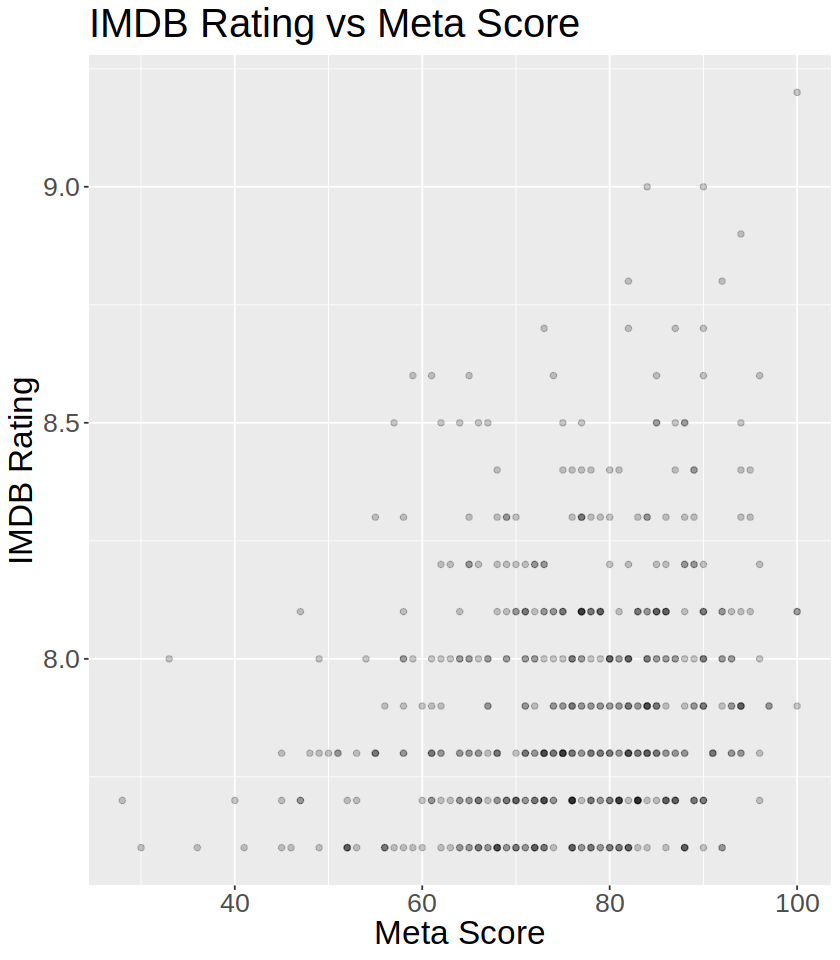

In [4]:
options(repr.plot.height = 8, repr.plot.width = 7)

movies_eda <- movies_training |>
    ggplot(aes(x = Meta_score, y = IMDB_Rating)) +
        geom_point(alpha = 0.2) +
        xlab("Meta Score") +
        ylab("IMDB Rating") +
        ggtitle("IMDB Rating vs Meta Score")+
theme(text = element_text(size = 20))
movies_eda

To best determine the relationship between the IMDB Rating and the Meta Score a linear regression was performed using Meta_score as the predictor and IMDB Rating as the response variable. The training data was fit to this workflow to predict parameters for the y-intercept and slope of the regression line.

In [5]:
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

# TODO: Swap variables
lm_recipe <- recipe(IMDB_Rating ~ Meta_score, data = movies_training)

lm_fit <- workflow() |>
  add_recipe(lm_recipe) |>
  add_model(lm_spec) |>
  fit(data = movies_training)
lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)   Meta_score  
   7.504036     0.005487  


The linear regression line was then plotted against the training data to visualize how well it fits the data.

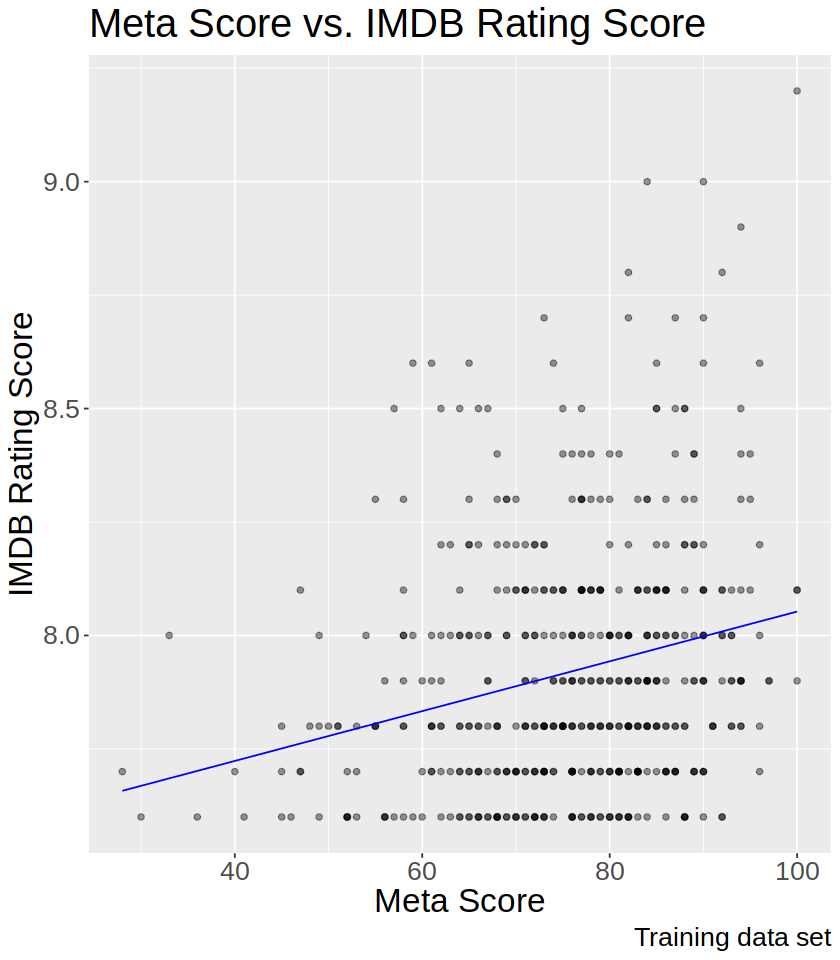

In [6]:
movies_preds <- lm_fit |>
   predict(movies_training) |>
   bind_cols(movies_training)

lm_predictions <- movies_preds |>
    ggplot(aes(x = Meta_score, y = IMDB_Rating)) +
        geom_point(alpha = 0.4) +
        geom_line(
            mapping = aes(x = Meta_score, y = .pred), 
            color = "blue") +
            labs(x="Meta Score", y="IMDB Rating Score", title="Meta Score vs. IMDB Rating Score", caption="Training data set")+
        theme(text = element_text(size = 20))
lm_predictions

In [7]:
lm_training_results <- lm_fit |>
         predict(movies_training) |>
         bind_cols(movies_training) |>
         metrics(truth = IMDB_Rating, estimate = .pred)

lm_rmse <- lm_training_results |>
          filter(.metric == "rmse") |>
          select(.estimate) |>
          pull()

lm_rmse

[1] 0.27

In [8]:
# TODO: We should calculate this, it will help us determine how good our prediction is.
lm_test_results <- lm_fit |>
         predict(movies_testing) |>
         bind_cols(movies_testing) |>
         metrics(truth = IMDB_Rating, estimate = .pred)

lm_rmspe <- lm_test_results |>
          filter(.metric == "rmse") |>
          select(.estimate) |>
          pull()


lm_rmspe

[1] 0.2990803

The testing data set was then compared to their predictions based on our model and plotted against the line of best fit calculated above.

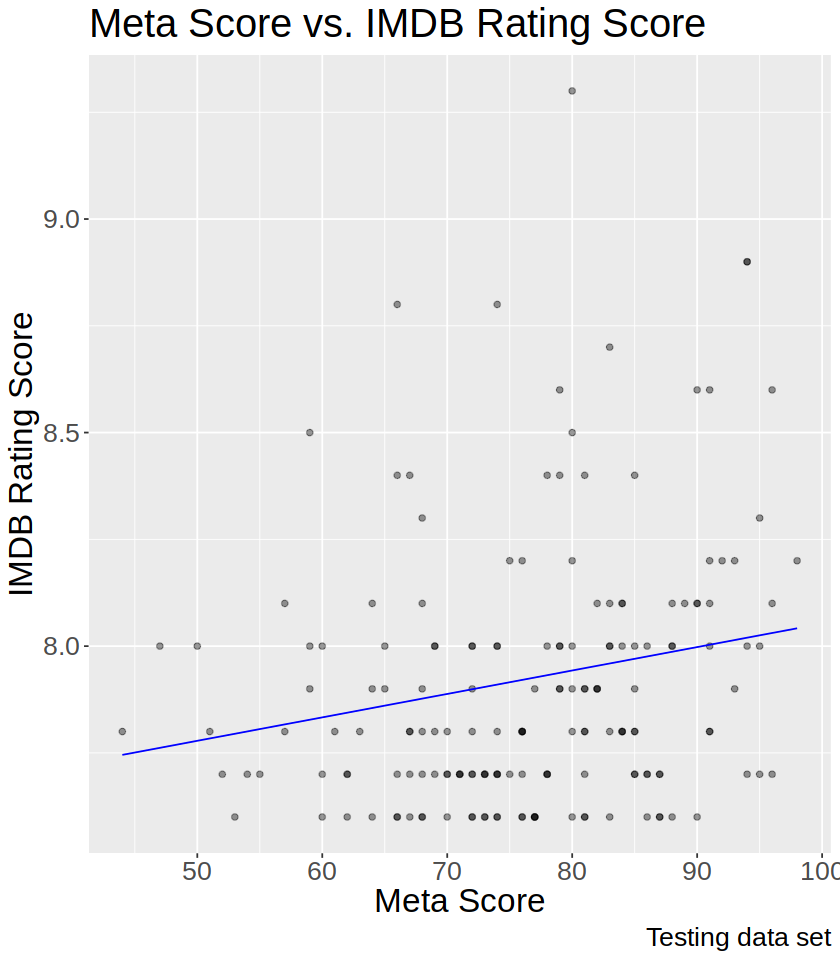

In [9]:
test_preds <-  lm_fit |>
   predict(movies_testing) |>
   bind_cols(movies_testing)

lm_predictions_test <- test_preds |>
     ggplot(aes(x = Meta_score, y =IMDB_Rating )) +
         geom_point(alpha = 0.4) +
         geom_line(
             mapping = aes(x = Meta_score, y = .pred), 
             color = "blue") +
        labs(x="Meta Score", y="IMDB Rating Score", title="Meta Score vs. IMDB Rating Score", caption="Testing data set")+
         theme(text = element_text(size = 20))
lm_predictions_test
#TODO: in general we should try and get rid of the warning messages. I think this should be done when we remove NA values from our training/testing set.

## Expected Outcomes and Significance:

As we can see our $RMSE$ when assessing model goodness of fit on the training data is quite low and our $RMSPE$ when assessing model prediction quality on a test data set is also low. This means that our linear regression line fits the data well and that our predictions are accurate. 

This is expected that the Meta Scores and IMDb Rating will have a weak positive relationship. Critics are trying to give audiences an accurate expectation on the film based on their ratings so both scoring/rating systems should correlate positively with each other. However, critics and general audiences often look for different things in their ratings, producing more variability between the two ratings, potentially causing a weaker relationship. This relationship will allow audiences to understand how a meta score should factor into their decision to see a movie before any general audience ratings are available.

As we mentioned in the introduction, IMDb is great for seeing what general audiences think of a movie. If you don't care what the critics say and want to see what people like yourself thought of a film, then you should use IMDb. We must, however, be aware that fans often skew the vote with 10-star ratings or 1-star ratings, which makes the score vary significantly. Next time you are trying to decide whether a film is worth watching, we would suggest using both IMDb and Meta Score as one focuses on user reviews while the other is a weighted average of reviews from top critics and publications.

## Resources:
How Meta Scores are computed:

How do you compute metascores? – metacritic support. Metacritic Support. (2023, October). https://metacritichelp.zendesk.com/hc/en-us/articles/14478499933079-How-do-you-compute-METASCORES-

Factors that influence Meta Scores (critics):

Gruber, M. (2022, April 20). How critics produce a film analysis. Ready Steady Cut. https://readysteadycut.com/2022/04/20/how-critics-produce-a-film-analysis/

Factors that effect IMDB score (a report):

Türker, B. (2021, August 17). Eda project - what are the factors affecting IMDB ratings?. Medium. https://medium.com/i%CC%87stanbuldatascienceacademy/eda-project-what-are-the-factors-affecting-imdb-ratings-e91f41396c89

Inconsistency in how movie critics and general viewers judge films:

Collazo, M. (2014, April 30). How movie critics and moviegoers view films differently. The Artifice. https://the-artifice.com/movie-critics-and-moviegoers-view-films-differently/

Data Set Origin:

Shankhdhar, H. (2021, February 1). IMDB movies dataset. Kaggle. https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows